# Leveraging the Word vec Result to clustering
### Classify industries according to BERT result

In [387]:
import pandas as pd
import numpy as np
from functools import reduce
from operator import itemgetter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA, TruncatedSVD
from scipy import stats
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth',100)

In [2]:
file=eval(open('company dic i.txt').read())
comp_corr=dict(file)

In [3]:
max_num=len(comp_corr)
comp_corr=[(key,[(subkey,subitem) for subkey,subitem in item.items()]) for key,item in comp_corr.items()]
comp_corr.sort(key=lambda x:x[0])
company_index=dict([(i,comp_corr[i][0]) for i in range(max_num)])
cov_matrix=[list(map(lambda x: x[1],sorted(comp_corr[0][1],key=lambda x: x[0])))]
for i in range(1,max_num):
    cov_matrix+=[list(map(lambda x: x[1],sorted(comp_corr[i][1],key=lambda x: x[0])))]
cov_matrix=np.matrix(cov_matrix)

In [4]:
#query all company in the same industry
def query_ind(index):
    if type(company_index[index])==type('a'):
        yield index
    else:
        sub_index=company_index[index]
        for i in sub_index:
            for j in query_ind(i):
                yield j

# sum correlation
def sum_corr_func(index1,index2):
    return cov_matrix_enlarge[index1,index2]

# set the corr of companies within the same industry to 1
def elim_corr(comp_list):
    for i in comp_list:
        cov_matrix_enlarge[i,:]=0
        cov_matrix_enlarge[:,i]=0

In [5]:
cov_matrix_enlarge=np.copy(cov_matrix)
set_num_counter=list(range(max_num))
cur_num=max_num
exempt_set=set()
record_dummy = -1
while len(set(set_num_counter))>25:
    # get minimun correlation in the matrix
    min_pair=cov_matrix_enlarge.argmax()
    row=min_pair//cov_matrix_enlarge.shape[0]
    col=min_pair%cov_matrix_enlarge.shape[0]
    company_index[cur_num]=[row,col]
    if row == col:
        cov_matrix_enlarge[row, col] = 0
        continue
    cur_num+=1
    # calculate the new generated industry correlation with other companies
    ind_comp_list=[i for i in query_ind(row)]+[i for i in query_ind(col)]
    for i in ind_comp_list:
        exempt_set.add(i)
    exempt_set.add(row)
    exempt_set.add(col)
    new_corr=[]
    for iter_company in range(cov_matrix_enlarge.shape[1]):
        if_exempt=iter_company in exempt_set
        if (iter_company>=max_num) and (not if_exempt):
            iter_comp_com=[i for i in query_ind(iter_company)]
            sum_corr=sum([cov_matrix[i,j] for i in iter_comp_com for j in ind_comp_list])/(len(iter_comp_com)*len(ind_comp_list))**1.05
        elif not if_exempt:
            sum_corr=sum([sum_corr_func(i1,iter_company) for i1 in ind_comp_list])/len(ind_comp_list)
        else:
            sum_corr=0
        new_corr.append(sum_corr)
    cov_matrix_enlarge=np.vstack((cov_matrix_enlarge,np.matrix(new_corr)))
    cov_matrix_enlarge=np.hstack((cov_matrix_enlarge,np.transpose(np.matrix(new_corr+[0]))))
    # set the corr within the same industry to 1
    elim_corr(ind_comp_list)
    elim_corr([row,col])
    # record the companies that have been categorized
    for i in ind_comp_list:
        set_num_counter[i]=record_dummy
    record_dummy -= 1

In [6]:
# show the result
ind_dict=dict()
for i in set(set_num_counter):
    ind_dict[i]=set()
for i in range(len(set_num_counter)):
    ind_dict[set_num_counter[i]].add(company_index[i])
print('classes name is: ',ind_dict.keys())

classes name is:  dict_keys([-256, -255, -252, -250, -247, -244, -242, -202, -274, -273, -272, -271, -270, -269, -268, -267, -266, -265, -264, -263, -262, -260, -259, -258, -257])


In [7]:
paper_class=[[(name,key) for name in item] for key,item in ind_dict.items()]
paper_class=reduce(lambda x,y: x+y,paper_class)
paper_class=pd.DataFrame(paper_class,columns=['company','paper_class'])
paper_class.head()

,company,paper_class
0,600025.SH,-256
1,600068.SH,-256
2,600438.SH,-256
3,600795.SH,-256
4,600900.SH,-256


### Official classification

In [69]:
official_class=pd.read_csv("hs300_official_class.csv")
official_class['股票代码']=official_class['股票代码'].map(lambda x:'0'*(6-len(str(x)))+str(x)+'.SZ' if len(str(x))<6 or str(x)[0]=='3' else str(x)+'.SH')
official_class.sort_values(by='股票代码',inplace=True)
official_class.rename(columns={'股票代码':'company'},inplace=True)
print('official classification number is: ',len(official_class.groupby('主营行业').groups))##groups returns a dictionary{group name: element index}
le=LabelEncoder()
official_label=le.fit_transform(official_class['主营行业'])
official_class.insert(2,'class',official_label)
official_class.head()

official classification number is:  25


,company,主营行业,class
299,000001.SZ,金融,21
298,000002.SZ,房地产,12
297,000063.SZ,信息技术,2
296,000069.SZ,房地产,12
295,000100.SZ,家电,9


### Comparable Model: k-means

In [9]:
# another comparable model: k-means model
estimator=KMeans(n_clusters=25)
estimator.fit(cov_matrix)
label_pred=estimator.labels_
centroids=estimator.cluster_centers_
inertia=estimator.inertia_

In [61]:
kmean_class=pd.DataFrame(zip([i for i in company_index.values()],label_pred),columns=['company','kmean_class'])
kmean_class.head()

,company,kmean_class
0,000001.SZ,5
1,000002.SZ,13
2,000063.SZ,10
3,000069.SZ,13
4,000100.SZ,10


### Identify classifacation effect

In [72]:
combine_class=official_class.merge(kmean_class,on=['company'],how='right')
combine_class=combine_class.merge(paper_class,on=['company'])

In [91]:
pca=PCA(n_components=2)
truncatedsvd=TruncatedSVD(n_components=2)
reduced_cov_pca=pd.DataFrame(pca.fit_transform(cov_matrix),columns=['pca1','pca2'])
reduced_cov_svd=pd.DataFrame(truncatedsvd.fit_transform(cov_matrix),columns=['svd1','svd2'])
combine_class_pca=pd.concat([combine_class,reduced_cov_pca],axis=1)
combine_class_svd=pd.concat([combine_class,reduced_cov_svd],axis=1)
combine_class_pca[['class','kmean_class','paper_class']]=combine_class_pca[['class','kmean_class','paper_class']].astype('category')
combine_class_svd[['class','kmean_class','paper_class']]=combine_class_svd[['class','kmean_class','paper_class']].astype('category')

In [92]:
combine_class_pca.head()

,company,主营行业,class,kmean_class,paper_class,pca1,pca2
0,000001.SZ,金融,21,5,-252,-0.270357,0.850367
1,000002.SZ,房地产,12,13,-270,-0.040719,-0.104807
2,000063.SZ,信息技术,2,10,-262,-0.038692,-0.053941
3,000069.SZ,房地产,12,13,-270,-0.111135,-0.171067
4,000100.SZ,家电,9,10,-274,0.194707,-0.184710


Text(0.5, 1.0, 'paper class distribution')

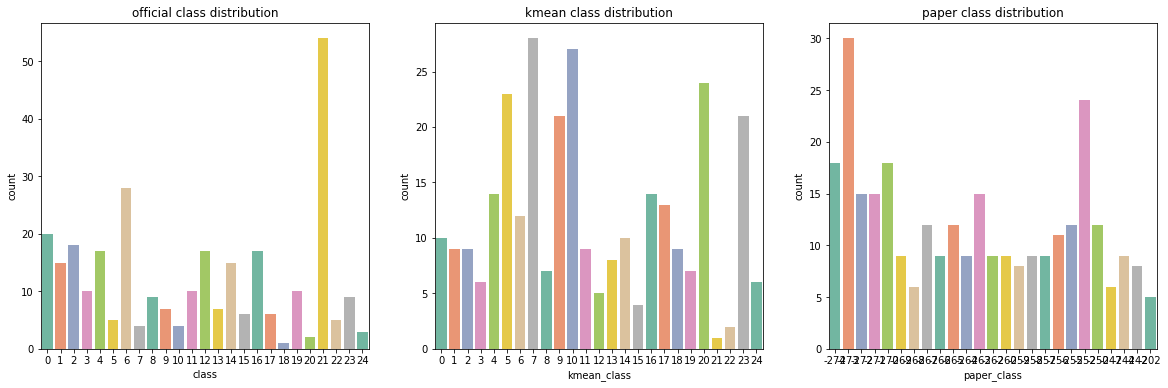

In [334]:
fig, ax= plt.subplots(1,3,figsize=(20,6))
plt.subtitle('Company number in different industry')

sns.countplot(combine_class['class'],ax=ax[0],palette='Set2')
ax[0].set_title('official class distribution')
sns.countplot(combine_class['kmean_class'],ax=ax[1],palette='Set2')
ax[1].set_title('kmean class distribution')
sns.countplot(combine_class['paper_class'],ax=ax[2],palette='Set2')
ax[2].set_title('paper class distribution')

Text(0.5, 1.0, 'paper class in SVD')

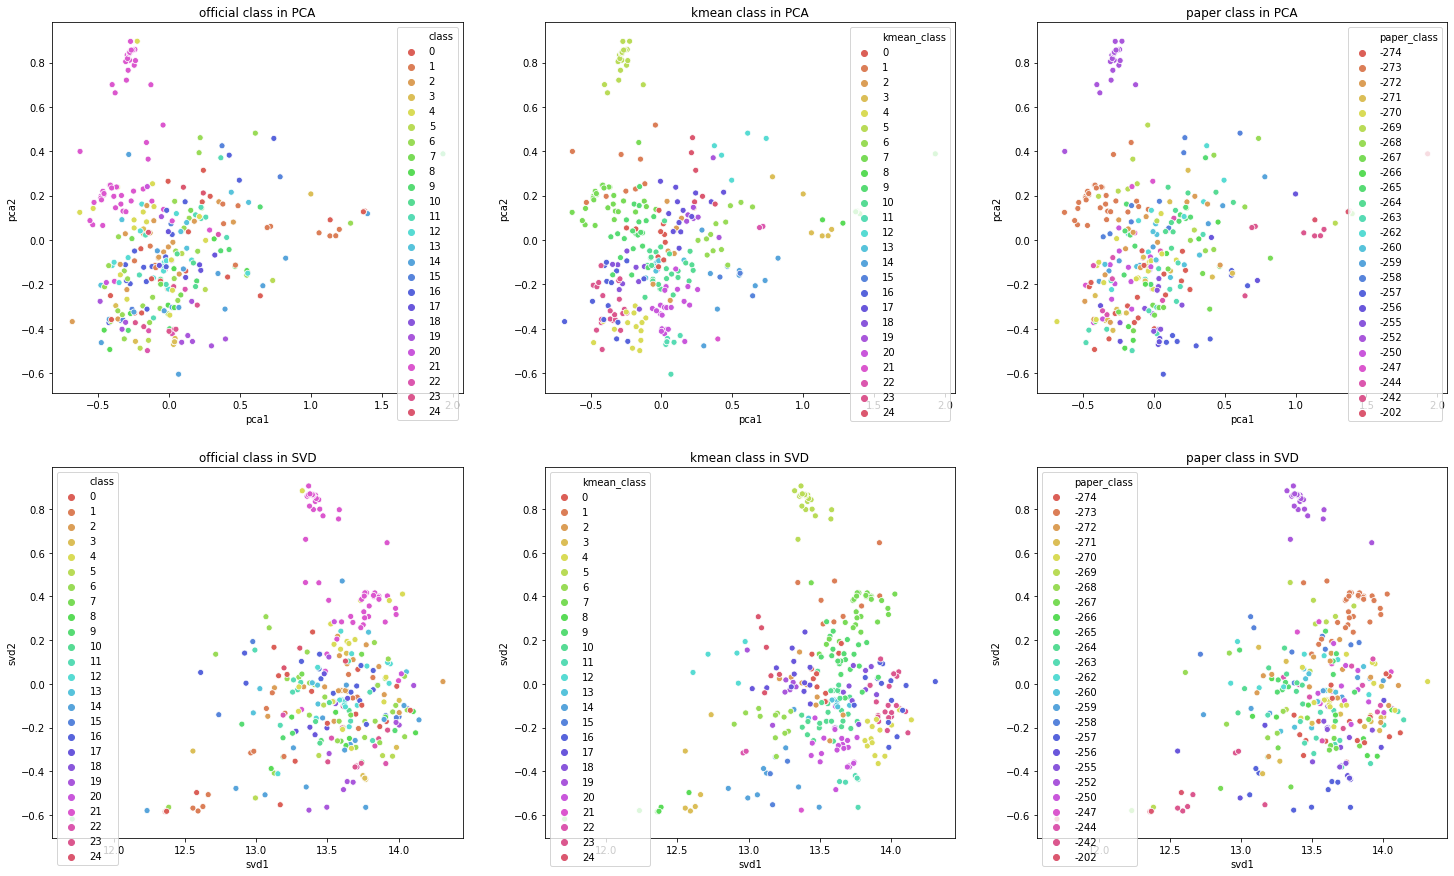

In [110]:
f,ax=plt.subplots(2,3,figsize=(25,15))
plt.subtitle('Classification use dimensionality reduce',fontsize=15)

sns.scatterplot(x='pca1',y='pca2',hue='class',data=combine_class_pca,ax=ax[0,0],palette=sns.color_palette("hls", 25))
ax[0,0].set_title('official class in PCA')
sns.scatterplot(x='pca1',y='pca2',hue='kmean_class',data=combine_class_pca,ax=ax[0,1],palette=sns.color_palette("hls", 25))
ax[0,1].set_title('kmean class in PCA')
sns.scatterplot(x='pca1',y='pca2',hue='paper_class',data=combine_class_pca,ax=ax[0,2],palette=sns.color_palette("hls", 25))
ax[0,2].set_title('paper class in PCA')
sns.scatterplot(x='svd1',y='svd2',hue='class',data=combine_class_svd,ax=ax[1,0],palette=sns.color_palette("hls", 25))
ax[1,0].set_title('official class in SVD')
sns.scatterplot(x='svd1',y='svd2',hue='kmean_class',data=combine_class_svd,ax=ax[1,1],palette=sns.color_palette("hls", 25))
ax[1,1].set_title('kmean class in SVD')
sns.scatterplot(x='svd1',y='svd2',hue='paper_class',data=combine_class_svd,ax=ax[1,2],palette=sns.color_palette("hls", 25))
ax[1,2].set_title('paper class in SVD')

### Test individual return with class return

In [143]:
import tushare as ts
ts.set_token('1dad4f86f90aa240de1a30832a5e1ff4e13c646685852f4f7ac30832')
pro=ts.pro_api()

In [310]:
## validation time 2019/06/30-2019/12/31
return_data=pd.read_csv('stock return 20190630-20191231.csv')[['ts_code','trade_date','pct_chg']]
return_data['trade_date']=pd.to_datetime(return_data['trade_date'],format='%Y%m%d')
return_data.rename(columns={'ts_code':'company','trade_date':'date','pct_chg':'return'},inplace=True)
return_data=return_data.merge(combine_class,on=['company'])
return_data.drop(columns=['主营行业'],inplace=True)
print('return data looks like this: ')
return_data.head()

,company,date,return,class,kmean_class,paper_class
0,000001.SZ,2019-08-20,0.4692,21,5,-252
1,000001.SZ,2019-08-19,0.1342,21,5,-252
2,000001.SZ,2019-08-16,-0.2677,21,5,-252
3,000001.SZ,2019-08-15,-0.2004,21,5,-252
4,000001.SZ,2019-08-14,0.5373,21,5,-252


In [317]:
## company2ind = {company name: class index }
## class_return_map = {class index : pd.DataFrame which contain company return in this class}

company=[i for i in combine_class['company']]
company2ind_paper=dict(zip(combine_class['company'],combine_class['paper_class']))
company2ind_kmean=dict(zip(combine_class['company'],combine_class['kmean_class']))
company2ind_official=dict(zip(combine_class['company'],combine_class['class']))

paper_class_mean=return_data.groupby(by=['paper_class','date']).mean()['return']
kmean_class_mean=return_data.groupby(by=['kmean_class','date']).mean()['return']
official_class_mean=return_data.groupby(by=['class','date']).mean()['return']
                          
paper_class_return_map={i:pd.DataFrame(paper_class_mean[i,]) for i in paper_class_mean.index.levels[0]}
kmean_class_return_map={i:pd.DataFrame(kmean_class_mean[i,]) for i in kmean_class_mean.index.levels[0]}
official_class_return_map={i:pd.DataFrame(official_class_mean[i,]) for i in official_class_mean.index.levels[0]}


In [318]:
for i in company:
    company_class=company2ind_paper[i]
    new_return=return_data[return_data['company']==i][['date','return']].set_index('date').rename(columns={'return':i})
    paper_class_return_map[company_class]=paper_class_return_map[company_class].join(new_return)

for i in company:
    company_class=company2ind_kmean[i]
    new_return=return_data[return_data['company']==i][['date','return']].set_index('date').rename(columns={'return':i})
    kmean_class_return_map[company_class]=kmean_class_return_map[company_class].join(new_return)
    
for i in company:
    company_class=company2ind_official[i]
    new_return=return_data[return_data['company']==i][['date','return']].set_index('date').rename(columns={'return':i})
    official_class_return_map[company_class]=official_class_return_map[company_class].join(new_return)

In [338]:
print('class_return_map looks like this: ')
paper_class_return_map[-257].head()

,return,002294.SZ,600028.SH,600111.SH,600309.SH,600489.SH,601088.SH,601225.SH,601857.SH,601898.SH
date,,,,,,,,,,
2019-07-01,0.720922,2.6363,0.1828,-1.9470,2.5941,-0.8763,0.0981,1.4069,0.7267,1.6667
2019-07-02,-0.016244,0.1306,-0.7299,-0.7943,-0.8656,-0.2947,1.0784,2.0277,-0.2886,-0.4098
2019-07-03,-0.872611,-0.6522,-1.1029,-2.4019,-1.6544,1.2808,0.2425,-2.7197,-0.4342,-0.4115
2019-07-04,-0.452556,-1.1379,1.3011,0.2461,0.1402,-3.5992,-0.6773,-0.4301,0.2907,-0.2066
2019-07-05,0.224733,0.2656,-0.5505,-0.1637,1.4466,1.4127,0.3897,0.2160,-0.5797,-0.4141


In [419]:
statistical_discribe_paper={key:pd.DataFrame(columns=item.columns,index=['abs_slope','p','significance','R2']) for key,item in paper_class_return_map.items()}
statistical_discribe_kmean={key:pd.DataFrame(columns=item.columns,index=['abs_slope','p','significance','R2']) for key,item in kmean_class_return_map.items()}
statistical_discribe_official={key:pd.DataFrame(columns=item.columns,index=['abs_slope','p','significance','R2']) for key,item in official_class_return_map.items()}

## stats.linregress return [slope, intercept, r_value, p_value, std_err]
## sum of significance is sum of the unsignificant number
## significance level: 99.9%

for i in statistical_discribe_paper:
    reg=[itemgetter(0,2,3)(stats.linregress(paper_class_return_map[i][j][paper_class_return_map[i][j].isna()==False],paper_class_return_map[i]['return'][paper_class_return_map[i][j].isna()==False])) for j in paper_class_return_map[i].columns]
    statistical_discribe_paper[i].loc['significance']=list(map(lambda x:x[2]<0.001,reg))
    statistical_discribe_paper[i].loc['p']=list(map(lambda x: x[2],reg))
    statistical_discribe_paper[i].loc['R2']=list(map(lambda x:x[1]**2,reg))
    statistical_discribe_paper[i].loc['abs_slope']=list(map(lambda x:abs(x[0]),reg))
    statistical_discribe_paper[i]['sum'+str(i)]=statistical_discribe_paper[i].mean(axis=1)
    statistical_discribe_paper[i].loc['significance','sum'+str(i)]=sum(statistical_discribe_paper[i].loc['significance',]==False)
    statistical_discribe_paper[i].drop(columns='return',inplace=True)
    
for i in statistical_discribe_kmean:
    reg=[itemgetter(0,2,3)(stats.linregress(kmean_class_return_map[i][j][kmean_class_return_map[i][j].isna()==False],kmean_class_return_map[i]['return'][kmean_class_return_map[i][j].isna()==False])) for j in kmean_class_return_map[i].columns]
    statistical_discribe_kmean[i].loc['significance']=list(map(lambda x:x[2]<0.001,reg))
    statistical_discribe_kmean[i].loc['p']=list(map(lambda x:x[2],reg))
    statistical_discribe_kmean[i].loc['R2']=list(map(lambda x:x[1]**2,reg))
    statistical_discribe_kmean[i].loc['abs_slope']=list(map(lambda x:abs(x[0]),reg))
    statistical_discribe_kmean[i]['sum'+str(i)]=statistical_discribe_kmean[i].mean(axis=1)
    statistical_discribe_kmean[i].loc['significance','sum'+str(i)]=sum(statistical_discribe_kmean[i].loc['significance',]==False)
    statistical_discribe_kmean[i].drop(columns='return',inplace=True)
    
for i in statistical_discribe_official:
    reg=[itemgetter(0,2,3)(stats.linregress(official_class_return_map[i][j][official_class_return_map[i][j].isna()==False],official_class_return_map[i]['return'][official_class_return_map[i][j].isna()==False])) for j in official_class_return_map[i].columns]
    statistical_discribe_official[i].loc['significance']=list(map(lambda x:x[2]<0.001,reg))    
    statistical_discribe_official[i].loc['p']=list(map(lambda x:x[2],reg))
    statistical_discribe_official[i].loc['R2']=list(map(lambda x:x[1]**2,reg))
    statistical_discribe_official[i].loc['abs_slope']=list(map(lambda x:abs(x[0]),reg))
    statistical_discribe_official[i]['sum'+str(i)]=statistical_discribe_official[i].mean(axis=1)
    statistical_discribe_official[i].loc['significance','sum'+str(i)]=sum(statistical_discribe_official[i].loc['significance',]==False)
    statistical_discribe_official[i].drop(columns='return',inplace=True)

In [420]:
statistical_discribe_paper[-257]

,002294.SZ,600028.SH,600111.SH,600309.SH,600489.SH,601088.SH,601225.SH,601857.SH,601898.SH,sum-257
abs_slope,0.225512,0.697705,0.220149,0.269601,0.169899,0.430552,0.385927,0.662449,0.301966,4.363761e-01
p,2.72273e-10,6.38537e-17,6.91567e-10,9.70145e-12,7.52618e-07,4.16448e-14,4.4529e-14,3.716e-20,2.79677e-13,7.535916e-08
significance,True,True,True,True,True,True,True,True,True,0.000000e+00
R2,0.275844,0.431929,0.265097,0.313095,0.181093,0.370095,0.369423,0.495699,0.350716,4.052991e-01


In [450]:
wellness={'paper':statistical_discribe_paper,'kmean':statistical_discribe_kmean,'official':statistical_discribe_official}
wellness_summary={'paper':pd.DataFrame(index=['abs_slope','p','significance','R2']),
                 'kmean':pd.DataFrame(index=['abs_slope','p','significance','R2']),
                 'official':pd.DataFrame(index=['abs_slope','p','significance','R2'])}

for method in wellness_summary:
    for value in wellness[method].values():
        wellness_summary[method]=wellness_summary[method].join(value.iloc[:,-1])
    wellness_summary[method]['mean']=wellness_summary[method].mean(axis=1)
    wellness_summary[method].loc['significance','mean']=sum(wellness_summary[method].iloc[2,:-1])

In [451]:
wellness_summary['paper']

,sum-274,sum-273,sum-272,sum-271,sum-270,sum-269,sum-268,sum-267,sum-266,sum-265,sum-264,sum-263,sum-262,sum-260,sum-259,sum-258,sum-257,sum-256,sum-255,sum-252,sum-250,sum-247,sum-244,sum-242,sum-202,mean
abs_slope,0.314996,7.269882e-01,0.426742,4.295023e-01,0.423744,5.740610e-01,4.847331e-01,4.777947e-01,0.358492,5.806760e-01,4.903533e-01,0.475148,5.112864e-01,5.993824e-01,0.450561,4.445613e-01,4.363761e-01,4.638001e-01,0.452102,7.329154e-01,4.963726e-01,4.975450e-01,0.363664,5.899066e-01,6.782917e-01,0.499200
p,0.008903,2.395692e-07,0.000516,3.270147e-07,0.000016,4.207428e-07,1.866356e-08,5.902838e-07,0.000001,7.656680e-08,1.988947e-07,0.000003,1.134884e-09,5.958071e-13,0.000003,1.801766e-11,7.535916e-08,6.481044e-08,0.000156,5.552791e-21,5.991067e-10,1.487143e-10,0.000003,1.048444e-10,3.969628e-10,0.000384
significance,1.000000,0.000000e+00,1.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,3.000000
R2,0.317848,6.944466e-01,0.431703,4.034236e-01,0.422374,5.734725e-01,4.547589e-01,4.544612e-01,0.355615,5.778697e-01,4.756672e-01,0.440538,4.771505e-01,5.288338e-01,0.451471,4.406527e-01,4.052991e-01,4.312655e-01,0.478362,6.409324e-01,4.813910e-01,4.830707e-01,0.357735,5.645016e-01,6.912436e-01,0.481363


Mean of R square of official classification is:  0.5466959756060528
Mean of R square of kmeans classification is:  0.5120514815506491
Mean of R square of paper classification is:  0.48136344604801123


Text(0.5, 1.0, 'p value square of paper classification')

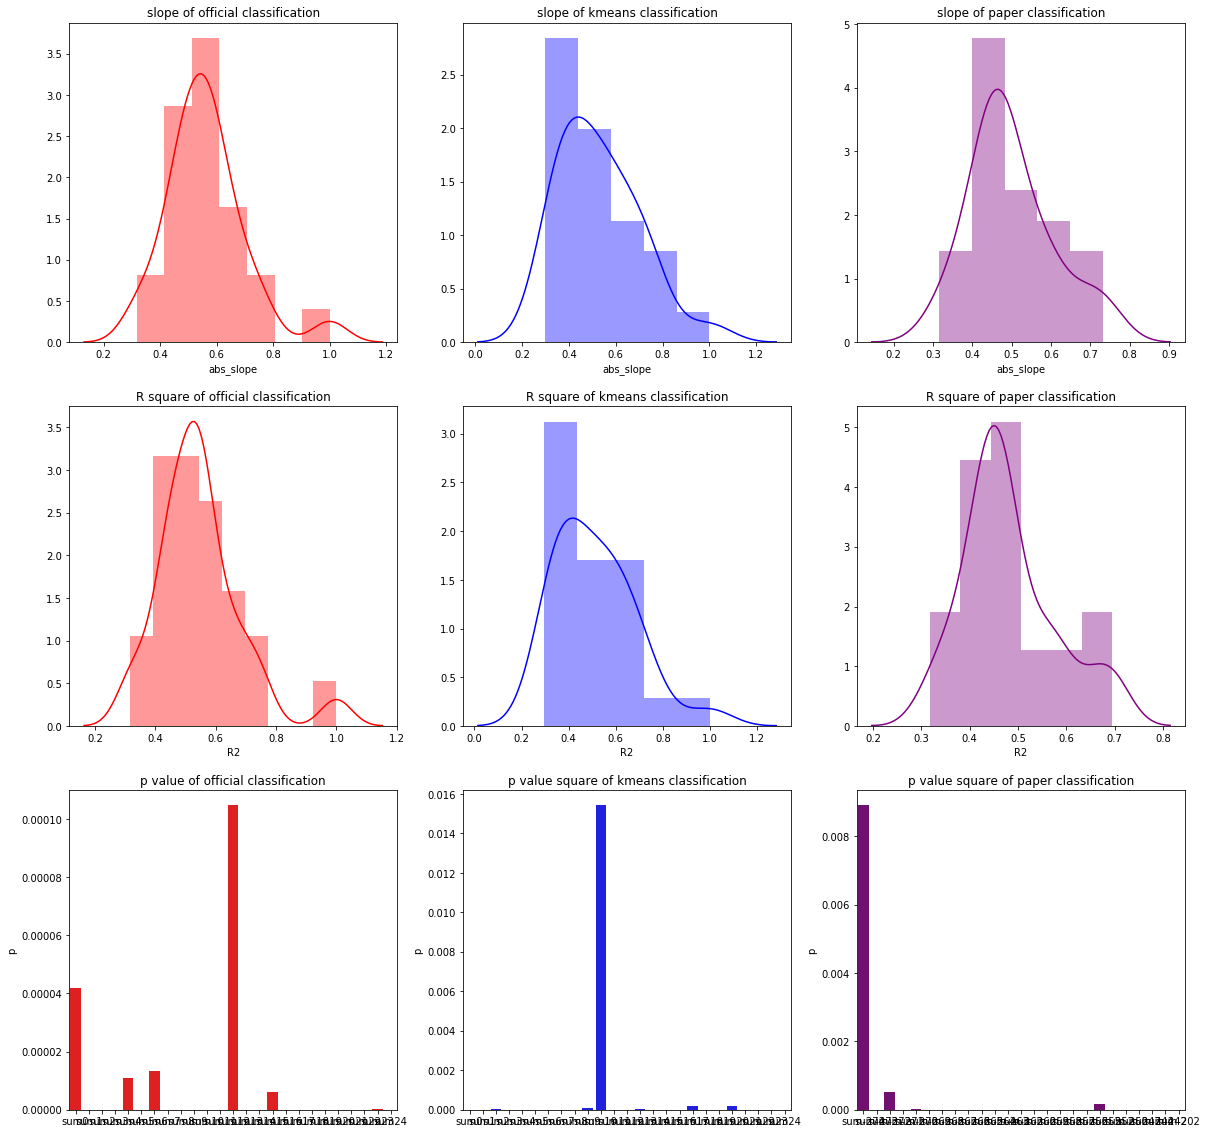

In [452]:
print('Mean of R square of official classification is: ',wellness_summary['official'].loc['R2','mean'])
print('Mean of R square of kmeans classification is: ',wellness_summary['kmean'].loc['R2','mean'])
print('Mean of R square of paper classification is: ',wellness_summary['paper'].loc['R2','mean'])
fig,ax=plt.subplots(3,3,figsize=(20,20))

sns.distplot(wellness_summary['official'].iloc[0,:-1],ax=ax[0,0],color='red')
ax[0,0].set_title('slope of official classification')
sns.distplot(wellness_summary['kmean'].iloc[0,:-1],ax=ax[0,1],color='blue')
ax[0,1].set_title('slope of kmeans classification')
sns.distplot(wellness_summary['paper'].iloc[0,:-1],ax=ax[0,2],color='purple')
ax[0,2].set_title('slope of paper classification')
sns.distplot(wellness_summary['official'].iloc[3,:-1],ax=ax[1,0],color='red')
ax[1,0].set_title('R square of official classification')
sns.distplot(wellness_summary['kmean'].iloc[3,:-1],ax=ax[1,1],color='blue')
ax[1,1].set_title('R square of kmeans classification')
sns.distplot(wellness_summary['paper'].iloc[3,:-1],ax=ax[1,2],color='purple')
ax[1,2].set_title('R square of paper classification')
sns.barplot(x=wellness_summary['official'].columns[:-1],y=wellness_summary['official'].iloc[1,:-1],ax=ax[2,0],color='red')
ax[2,0].set_title('p value of official classification')
sns.barplot(x=wellness_summary['kmean'].columns[:-1],y=wellness_summary['kmean'].iloc[1,:-1],ax=ax[2,1],color='blue')
ax[2,1].set_title('p value square of kmeans classification')
sns.barplot(x=wellness_summary['paper'].columns[:-1],y=wellness_summary['paper'].iloc[1,:-1],ax=ax[2,2],color='purple')
ax[2,2].set_title('p value square of paper classification')